In [18]:
'''
Author: Bryan Bo Cao
Email: boca7588@colorado.edu or bo.cao-1@colorado.edu
Github Repo: https://github.com/BryanBo-Cao/neuralnets-deeplearning
Some of the code is modified from "3_mnist_from_scratch from", "docker run -it -p 8888:8888 gcr.io/tensorflow/tensorflow"
'''
from __future__ import print_function

import tensorflow as tf
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
from importlib import import_module
from CIFAR_reader import CIFAR_reader # Reference: https://github.com/michael-iuzzolino/CIFAR_reader

In [19]:
cifar = CIFAR_reader(one_hot=True, verbose=True, img_size=32, num_classes=10, augment=False)

Checking for CIFAR data...
Extracting Data...
Unpacking data...
Loading training batch 1 of 5...
Loading training batch 2 of 5...
Loading training batch 3 of 5...
Loading training batch 4 of 5...
Loading training batch 5 of 5...
Loading testing batch 1 of 1...


In [20]:
IMAGE_SIZE = 32
PIXEL_DEPTH = 255
BATCH_SIZE = 128
N_CHANNELS = 3
N_LABELS = 10
SEED = 32

training_data = cifar.train
training_labels = cifar.labels
train_data = training_data['data']
train_labels = training_data['labels']

testing_data = cifar.test
test_data = testing_data['data']
test_data = np.float32(test_data)
test_labels = testing_data['labels']
test_labels = np.float32(test_labels)

N_TRAIN_IMAGE = len(train_data)
train_data = (train_data - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH
train_data = train_data.reshape(N_TRAIN_IMAGE, IMAGE_SIZE, IMAGE_SIZE, 3)

N_TEST_IMAGE = len(test_data)
test_data = (test_data - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH
test_data = test_data.reshape(N_TEST_IMAGE, IMAGE_SIZE, IMAGE_SIZE, 3)

#print("train_data[0]:", train_data[0])
#print("test_data[0]:", test_data[0])

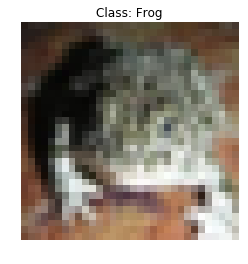

In [21]:
cifar.preview_data(data_set="training")

In [22]:
print (train_data.shape)
print (train_labels.shape)
print (test_data.shape)
print (test_labels.shape)

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


In [23]:
VALIDATION_SIZE = 10000

train_data = train_data[VALIDATION_SIZE:, :, :, :]
train_data = np.float32(train_data)
train_labels = train_labels[VALIDATION_SIZE:]
train_size = len(train_data)
validation_data = train_data[:VALIDATION_SIZE, :, :, :]
validation_data = np.float32(validation_data)
validation_labels = train_labels[:VALIDATION_SIZE]
validation_size = len(validation_data)

print('train_data.shape', train_data.shape)
print('validation_data.shape', validation_data.shape)
print('train_data size:', train_size)
print('validation_data size:', validation_size)
#print('validation_data:', validation_data)
#print('validation_labels: ', validation_labels)

N_TRAIN_IMAGE = train_size
print("N_TRAIN_IMAGE: ", N_TRAIN_IMAGE)

train_data.shape (40000, 32, 32, 3)
validation_data.shape (10000, 32, 32, 3)
train_data size: 40000
validation_data size: 10000
N_TRAIN_IMAGE:  40000


In [24]:
import tensorflow as tf

train_data_node = tf.placeholder(
  tf.float32,
  shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS))
train_labels_node = tf.placeholder(tf.float32,
                                   shape=(BATCH_SIZE, N_LABELS))

train_all_data_node = tf.constant(train_data)
validation_data_node = tf.constant(validation_data)
test_data_node = tf.constant(test_data)

conv1_weights = tf.Variable(
  tf.truncated_normal([5, 5, N_CHANNELS, 32],  # 5x5 filter, depth 32.
                      stddev=0.1,
                      seed=SEED))
conv1_biases = tf.Variable(tf.zeros([32]))
conv2_weights = tf.Variable(
  tf.truncated_normal([5, 5, 32, 64],
                      stddev=0.1,
                      seed=SEED))
conv2_biases = tf.Variable(tf.constant(0.1, shape=[64]))
fc1_weights = tf.Variable(  # fully connected, depth 512.
  tf.truncated_normal([IMAGE_SIZE // 4 * IMAGE_SIZE // 4 * 64, 512],
                      stddev=0.1,
                      seed=SEED))
fc1_biases = tf.Variable(tf.constant(0.1, shape=[512]))
fc2_weights = tf.Variable(
  tf.truncated_normal([512, N_LABELS],
                      stddev=0.1,
                      seed=SEED))
fc2_biases = tf.Variable(tf.constant(0.1, shape=[N_LABELS]))

print('Variables Initialized')

Variables Initialized


In [25]:
def model(data, train=False):
    """The Model definition."""
    # 2D convolution, with 'SAME' padding (i.e. the output feature map has
    # the same size as the input). Note that {strides} is a 4D array whose
    # shape matches the data layout: [image index, y, x, depth].
    conv = tf.nn.conv2d(data,
                        conv1_weights,
                        strides=[1, 1, 1, 1],
                        padding='SAME')

    # Bias and rectified linear non-linearity.
    relu = tf.nn.relu(tf.nn.bias_add(conv, conv1_biases))

    # Max pooling. The kernel size spec ksize also follows the layout of
    # the data. Here we have a pooling window of 2, and a stride of 2.
    pool = tf.nn.max_pool(relu,
                          ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME')
    conv = tf.nn.conv2d(pool,
                        conv2_weights,
                        strides=[1, 1, 1, 1],
                        padding='SAME')
    relu = tf.nn.relu(tf.nn.bias_add(conv, conv2_biases))
    pool = tf.nn.max_pool(relu,
                          ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME')

    # Reshape the feature map cuboid into a 2D matrix to feed it to the
    # fully connected layers.
    pool_shape = pool.get_shape().as_list()
    reshape = tf.reshape(
        pool,
        [pool_shape[0], pool_shape[1] * pool_shape[2] * pool_shape[3]])
  
    # Fully connected layer. Note that the '+' operation automatically
    # broadcasts the biases.
    hidden = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)

    # Add a 50% dropout during training only. Dropout also scales
    # activations such that no rescaling is needed at evaluation time.
    if train:
        hidden = tf.nn.dropout(hidden, 0.5, seed=SEED)
    return tf.matmul(hidden, fc2_weights) + fc2_biases

print('Model defined')

Model defined


In [26]:
# Training computation: logits + cross-entropy loss.
logits = model(train_data_node, True)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
  labels=train_labels_node, logits=logits))

# L2 regularization for the fully connected parameters.
regularizers = (tf.nn.l2_loss(fc1_weights) + tf.nn.l2_loss(fc1_biases) +
                tf.nn.l2_loss(fc2_weights) + tf.nn.l2_loss(fc2_biases))
# Add the regularization term to the loss.
loss += 5e-4 * regularizers

# Optimizer: set up a variable that's incremented once per batch and
# controls the learning rate decay.
batch = tf.Variable(0)
# Decay once per epoch, using an exponential schedule starting at 0.01.
learning_rate = tf.train.exponential_decay(
  0.01,                # Base learning rate.
  batch * BATCH_SIZE,  # Current index into the dataset.
  train_size,          # Decay step.
  0.95,                # Decay rate.
  staircase=True)
# Use simple momentum for the optimization.
optimizer = tf.train.MomentumOptimizer(learning_rate,
                                       0.9).minimize(loss,
                                                     global_step=batch)

# Predictions for the minibatch, validation set and test set.
train_prediction = tf.nn.softmax(logits)

# compute only by {eval()} method.
train_all_data_prediction = tf.nn.softmax(model(train_all_data_node))
validation_prediction = tf.nn.softmax(model(validation_data_node))
test_prediction = tf.nn.softmax(model(test_data_node))

print('Training computation: logits + cross-entropy loss done')

Training computation: logits + cross-entropy loss done


In [27]:
sess = tf.InteractiveSession()
sess.as_default()
tf.global_variables_initializer().run()

In [28]:
# Grab the first BATCH_SIZE examples and labels.
batch_data = train_data[:BATCH_SIZE, :, :, :]
batch_labels = train_labels[:BATCH_SIZE]

# This dictionary maps the batch data (as a numpy array) to the
# node in the graph it should be fed to.
feed_dict = {train_data_node: batch_data,
             train_labels_node: batch_labels}

# Run the graph and fetch some of the nodes.
_, l, lr, predictions = sess.run(
  [optimizer, loss, learning_rate, train_prediction],
  feed_dict=feed_dict)

print(batch_data.shape)
print(batch_labels.shape)
print('Run graph done.')

(128, 32, 32, 3)
(128, 10)
Run graph done.


In [29]:
print(predictions[0])

[  1.16982765e-01   1.42972870e-03   1.97592890e-05   3.99296312e-07
   8.81408807e-04   1.68743473e-03   1.40850125e-05   8.78815353e-01
   1.66529047e-04   2.52190534e-06]


In [30]:
# The highest probability in the first entry.
print('First prediction', np.argmax(predictions[0]))

# But, predictions is actually a list of BATCH_SIZE probability vectors.
print(predictions.shape)

# So, we'll take the highest probability for each vector.
print('All predictions', np.argmax(predictions, 1))

First prediction 7
(128, 10)
All predictions [7 5 5 1 5 1 6 0 0 7 5 4 2 1 5 4 5 2 0 1 0 0 5 5 5 1 1 5 4 5 7 5 1 0 2 0 5
 0 5 5 5 5 0 5 5 5 5 5 1 7 0 5 1 5 5 4 1 1 5 1 5 5 5 5 5 0 5 5 5 2 0 7 0 5
 7 0 1 5 5 7 9 7 4 5 5 9 1 5 5 0 5 5 5 5 5 5 5 1 5 5 0 5 4 0 5 5 4 0 5 1 4
 4 4 2 0 5 5 1 0 5 1 0 5 7 5 4 5 7]


In [31]:
print('Batch labels', np.argmax(batch_labels, 1))

Batch labels [1 6 6 8 8 3 4 6 0 6 0 3 6 6 5 4 8 3 2 6 0 3 1 4 0 6 6 2 7 6 9 0 4 5 7 1 6
 7 9 1 7 7 8 0 3 7 4 7 3 1 0 4 6 6 1 4 9 2 6 4 5 0 4 6 0 8 3 4 8 8 3 9 5 7
 1 9 4 7 9 1 9 7 5 2 7 3 4 8 8 2 1 5 9 2 7 8 8 6 8 8 1 3 8 8 5 4 7 1 6 6 1
 6 1 6 7 0 4 6 9 5 8 7 1 9 0 3 3 7]


In [32]:
correct = np.sum(np.argmax(predictions, 1) == np.argmax(batch_labels, 1))
total = predictions.shape[0]

print(float(correct) / float(total))

confusions = np.zeros([10, 10], np.float32)
bundled = zip(np.argmax(predictions, 1), np.argmax(batch_labels, 1))
for predicted, actual in bundled:
  confusions[predicted, actual] += 1

plt.grid(False)
plt.xticks(np.arange(N_LABELS))
plt.yticks(np.arange(N_LABELS))
plt.imshow(confusions, cmap=plt.cm.jet, interpolation='nearest');

0.1015625


In [33]:
def error_rate(predictions, labels):
    correct = np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
    total = predictions.shape[0]

    error = 100.0 - (100 * float(correct) / float(total))
    return error

print('Error rate defined')

def get_accuracy(predictions, labels):
    correct = np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
    total = predictions.shape[0]

    accuracy = float(correct) / float(total)
    accuracy_fig = ""
    accuracy_fig = str(correct)
    accuracy_fig += (" of ")
    accuracy_fig += str(total)
    return accuracy, accuracy_fig

print('get_accuracy defined')

Error rate defined
get_accuracy defined


In [34]:
#steps = train_size
steps = 500
for step in range(steps):
    offset = (step * BATCH_SIZE) % (train_size - BATCH_SIZE)
    batch_data = train_data[offset:(offset + BATCH_SIZE), :, :, :]
    batch_labels = train_labels[offset:(offset + BATCH_SIZE)]
    feed_dict = {train_data_node: batch_data, train_labels_node: batch_labels}
    _, l, lr, predictions = sess.run([optimizer, loss, learning_rate, train_prediction], feed_dict=feed_dict)
    
    if step % 5 == 0:
        print('Step %d of %d' % (step, steps))
        validation_accuracy, validation_accuracy_fig = get_accuracy(
              validation_prediction.eval(), validation_labels)
        print('Validation accuracy: %.6f%% (%s), Mini-batch loss: %.5f, Learning rate: %.5f' % 
              (validation_accuracy * 100, validation_accuracy_fig, l, lr))
        #feed_train_all_data_dict = {train_all_data_node: train_data}
        #train_accuracy, train_accuracy_fig = get_accuracy(
         #     train_all_data_prediction.eval(feed_dict=feed_train_all_data_dict), 
         #   train_labels)
        
        #train_accuracy, train_accuracy_fig = get_accuracy(
        #      train_all_data_prediction.eval(), train_labels)
        
        #print('Train accuracy: %.6f%% (%s), Mini-batch loss: %.5f, Learning rate: %.5f' % 
         #     (train_accuracy * 100, train_accuracy_fig, l, lr))

Step 0 of 500
Validation accuracy: 10.940000% (1094 of 10000), Mini-batch loss: 8.96989, Learning rate: 0.01000
Step 5 of 500
Validation accuracy: 12.410000% (1241 of 10000), Mini-batch loss: 7.36864, Learning rate: 0.01000
Step 10 of 500
Validation accuracy: 16.630000% (1663 of 10000), Mini-batch loss: 6.51252, Learning rate: 0.01000
Step 15 of 500
Validation accuracy: 18.060000% (1806 of 10000), Mini-batch loss: 6.34707, Learning rate: 0.01000
Step 20 of 500
Validation accuracy: 21.690000% (2169 of 10000), Mini-batch loss: 6.22292, Learning rate: 0.01000
Step 25 of 500
Validation accuracy: 24.370000% (2437 of 10000), Mini-batch loss: 6.30681, Learning rate: 0.01000
Step 30 of 500
Validation accuracy: 26.820000% (2682 of 10000), Mini-batch loss: 6.17990, Learning rate: 0.01000
Step 35 of 500
Validation accuracy: 26.730000% (2673 of 10000), Mini-batch loss: 6.16192, Learning rate: 0.01000
Step 40 of 500
Validation accuracy: 28.280000% (2828 of 10000), Mini-batch loss: 6.14630, Learning

Validation accuracy: 48.680000% (4868 of 10000), Mini-batch loss: 5.48614, Learning rate: 0.00950
Step 365 of 500
Validation accuracy: 49.120000% (4912 of 10000), Mini-batch loss: 5.34098, Learning rate: 0.00950
Step 370 of 500
Validation accuracy: 49.950000% (4995 of 10000), Mini-batch loss: 5.37984, Learning rate: 0.00950
Step 375 of 500
Validation accuracy: 50.100000% (5010 of 10000), Mini-batch loss: 5.36856, Learning rate: 0.00950
Step 380 of 500
Validation accuracy: 49.300000% (4930 of 10000), Mini-batch loss: 5.45897, Learning rate: 0.00950
Step 385 of 500
Validation accuracy: 49.440000% (4944 of 10000), Mini-batch loss: 5.32027, Learning rate: 0.00950
Step 390 of 500
Validation accuracy: 50.180000% (5018 of 10000), Mini-batch loss: 5.36415, Learning rate: 0.00950
Step 395 of 500
Validation accuracy: 49.950000% (4995 of 10000), Mini-batch loss: 5.51847, Learning rate: 0.00950
Step 400 of 500
Validation accuracy: 49.760000% (4976 of 10000), Mini-batch loss: 5.46389, Learning rate

In [35]:
test_accuracy, test_accuracy_fig = get_accuracy(test_prediction.eval(), test_labels)
print('Test accuracy: %.8f (%s)' % (test_accuracy, test_accuracy_fig))

Test accuracy: 0.50180000 (5018 of 10000)


In [ ]:
train_accuracy, train_accuracy_fig = get_accuracy(train_all_data_prediction.eval(), train_labels)
print('Train accuracy: %.8f (%s)' % (train_accuracy, train_accuracy_fig))